In [1]:
%load_ext autoreload
%autoreload 2

import datetime

import numpy as np
import pandas as pd
import gudhi

from traffic.core import Traffic, Flight
from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_persistence, remove_outliers_z_score, remove_outliers_dbscan
from functions.data_loading import linkage_cluster_persistances, flights_from_query

from scipy.cluster.hierarchy import fcluster

In [2]:
# load minimum data set
df = pd.read_csv("../../data/go_arounds_augmented.csv", low_memory=False)
df["time"] = pd.to_datetime(df["time"])

start = datetime.datetime(year=2019, month=1, day=1).replace(
    tzinfo=datetime.timezone.utc
)
stop = datetime.datetime(year=2024, month=1, day=1).replace(
    tzinfo=datetime.timezone.utc
)

#with_GA = df.query(f"has_ga & (@start <= time <= @stop)")
#without_GA = df.query(f"not has_ga & (@start <= time <= @stop)")

approach_1 = df.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = df.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = df.query(f"n_approaches==3 & (@start <= time <= @stop)")

In [3]:
count = approach_3.shape[0]
approach_2 = approach_2.sample(n=count, random_state=42)
approach_1 = approach_1.sample(n=count, random_state=42)
query = pd.concat([approach_1, approach_2, approach_3], axis=0)
flights, data = flights_from_query(query, "../../data/balanced1_2_3.pkl", load_results=False)

100%|██████████| 4599/4599 [00:29<00:00, 154.76it/s]


In [5]:
flights = list(filter(large_gap_filter, flights))
labels = data[:, 0]

trees, paths = flight_persistence(flights)

100%|██████████| 3039/3039 [00:44<00:00, 68.64it/s] 


In [9]:
path = f"../../data/linkage_clustering/cyclic_dataset.pkl"
Z = linkage_cluster_persistances(trees, path=path, dimension=1, load_results=False)

100%|██████████| 3039/3039 [00:31<00:00, 95.47it/s] 


In [10]:
clustering = fcluster(Z, t=10, criterion='maxclust')

for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 3037
2: 1
3: 1


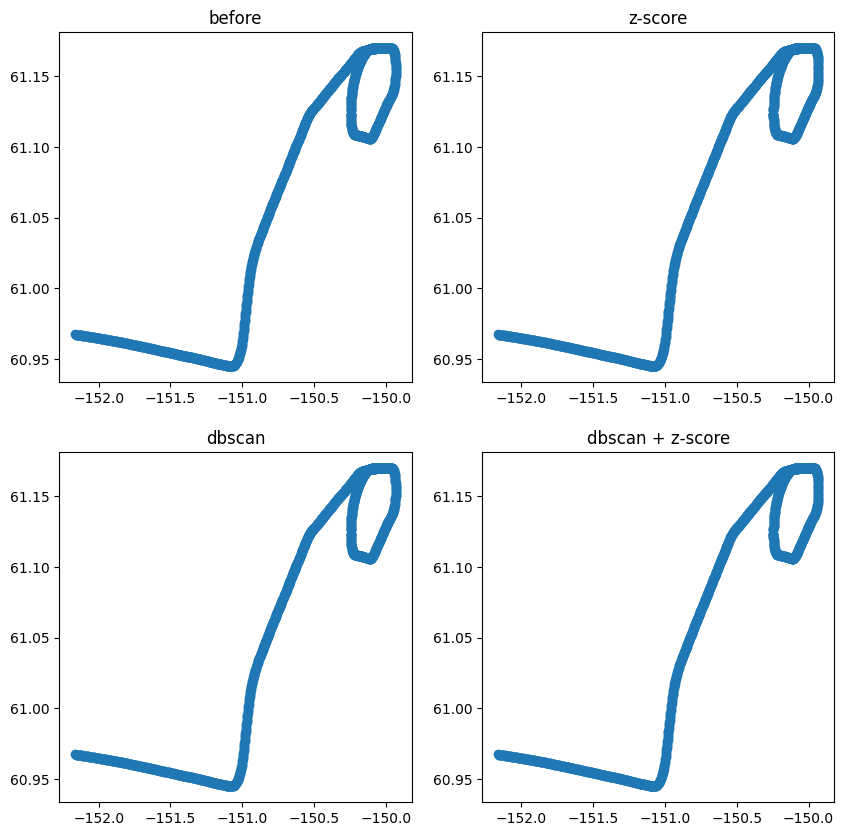

In [14]:
from matplotlib import pyplot as plt

ind = 2

flight = flights[np.where(clustering == ind)[0][0]]
tree = trees[np.where(clustering == ind)[0][0]]
points = paths[np.where(clustering == ind)[0][0]]
before = flight.data[["longitude", "latitude"]].to_numpy()

dbscan_paths        = before[remove_outliers_dbscan(before, 25, eps = 0.05)]
z_score_paths       = before[remove_outliers_z_score(before)]
both_bethods_paths  = dbscan_paths[remove_outliers_z_score(dbscan_paths)]

path_filters = [(before, "before"), (z_score_paths, "z-score"), (dbscan_paths, "dbscan"), (both_bethods_paths, "dbscan + z-score")]

fig, axs = plt.subplots((len(path_filters)+1)//2, 2)#, sharex=True, sharey=True)
for i, (path, name) in enumerate(path_filters):
    axs[i//2, i%2].scatter(path[:, 0], path[:, 1])
    axs[i//2][i%2].set_title(name)

fig.set_figheight(10)
fig.set_figwidth(10)

In [9]:
gudhi.persistence_graphical_tools.plot_persistence_diagram(tree, axes=axs[1])
print(tree)

AttributeError: 'numpy.ndarray' object has no attribute 'add_patch'

In [ ]:
fig = plt.scatter(points[:, 1], points[:, 0])
plt.show()